In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
#df = pd.read_csv('../data/Modelar_UH2021.txt', sep="|", decimal = ",")
df = pd.read_csv('Modelar_UH2021.txt', sep="|", decimal = ",")

In [3]:
df.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0.0,0.0,5241.0,0.0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,6.07,0.0,0.0,5241.0,3.0
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0.0,0.0,NaN,0.0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0.0,0.0,NaN,0.0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0.0,0.0,4064.0,0.0


In [4]:
df.shape

(147583, 11)

In [5]:
df.dtypes

fecha                 object
id                     int64
visitas                int64
categoria_uno         object
categoria_dos        float64
estado                object
precio               float64
dia_atipico          float64
campaña              float64
antiguedad           float64
unidades_vendidas    float64
dtype: object

In [6]:
df[['estado']].value_counts(sort=False)

estado   
No                1
No Rotura    129209
Rotura        16030
Transito       2343
dtype: int64

Buscamos valores null en las columnas que forman el conjunto de datos.

In [7]:
missing_columns = df.columns[df.isna().any()].tolist()
missing_columns

['categoria_dos',
 'precio',
 'dia_atipico',
 'campaña',
 'antiguedad',
 'unidades_vendidas']

Podemos observar que hay tres columnas con valores nulos. Ahora lo que vamos a hacer es ver con cuántos valores nulos cuenta cada una de ellas y de esta manera, decidir de qué forma tratarlos.

In [8]:
missing_data = df.isnull() # Los valores null se representan como True

for column in missing_columns:
    print(column)
    print (missing_data[column].value_counts())
    print("")

categoria_dos
False    147369
True        214
Name: categoria_dos, dtype: int64

precio
True     106072
False     41511
Name: precio, dtype: int64

dia_atipico
False    147582
True          1
Name: dia_atipico, dtype: int64

campaña
False    147582
True          1
Name: campaña, dtype: int64

antiguedad
False    115721
True      31862
Name: antiguedad, dtype: int64

unidades_vendidas
False    147582
True          1
Name: unidades_vendidas, dtype: int64



Cantidad de valores null por columna:
* `categoria_dos`: 5844
* `precio`: 1402111
* `antiguedad`: 874165

Para tratar los valores nulos de la columna `categoria_dos` vamos a reemplazarlos por el valor más frecuente de esta:

In [9]:
most_freq = df['categoria_dos'].mode().values[0]
most_freq

307.0

In [10]:
df['categoria_dos'].replace(np.nan, most_freq, inplace=True)

Para tratar los valores nulos de la columna `precio` vamos a realizar lo que se indica en las instrucciones del reto "*Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.*"

In [ ]:
#TODO

Para tratar los valores nulos de la columna `antiguedad` vamos a reemplazarlos por la media de esta columna:

In [11]:
mean_val = int(df['antiguedad'].mean())
mean_val

1019

In [12]:
df['antiguedad'].replace(np.nan, mean_val, inplace=True)

Vamos a cambiar los tipos de datos de las columnas para poder tratarlos en un futuro.

In [31]:
df[['categoria_uno', 'estado', "categoria_dos"]] = df[['categoria_uno', 'estado', "categoria_dos"]].astype(str)
df['fecha'] = pd.to_datetime(df['fecha'])

print(df.dtypes)
df.head()


fecha                datetime64[ns]
id                            int64
visitas                       int64
categoria_uno                object
categoria_dos                object
estado                       object
precio                      float64
dia_atipico                 float64
campaña                     float64
antiguedad                  float64
unidades_vendidas           float64
dtype: object


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-01-06,21972,0,C,75.0,No Rotura,NaN,0.0,0.0,5241.0,0.0
1,2015-01-06,23910,5,C,170.0,No Rotura,6.07,0.0,0.0,5241.0,3.0
2,2015-01-06,24306,13,A,46.0,No Rotura,NaN,0.0,0.0,1019.0,0.0
3,2015-01-06,24306,13,A,46.0,No Rotura,NaN,0.0,0.0,1019.0,0.0
4,2015-01-06,27144,15,E,230.0,No Rotura,NaN,0.0,0.0,4064.0,0.0


Aquí podemos visualizar las ventas por meses para poder distinguir si hay una diferencia notoria de ventas entre ellos

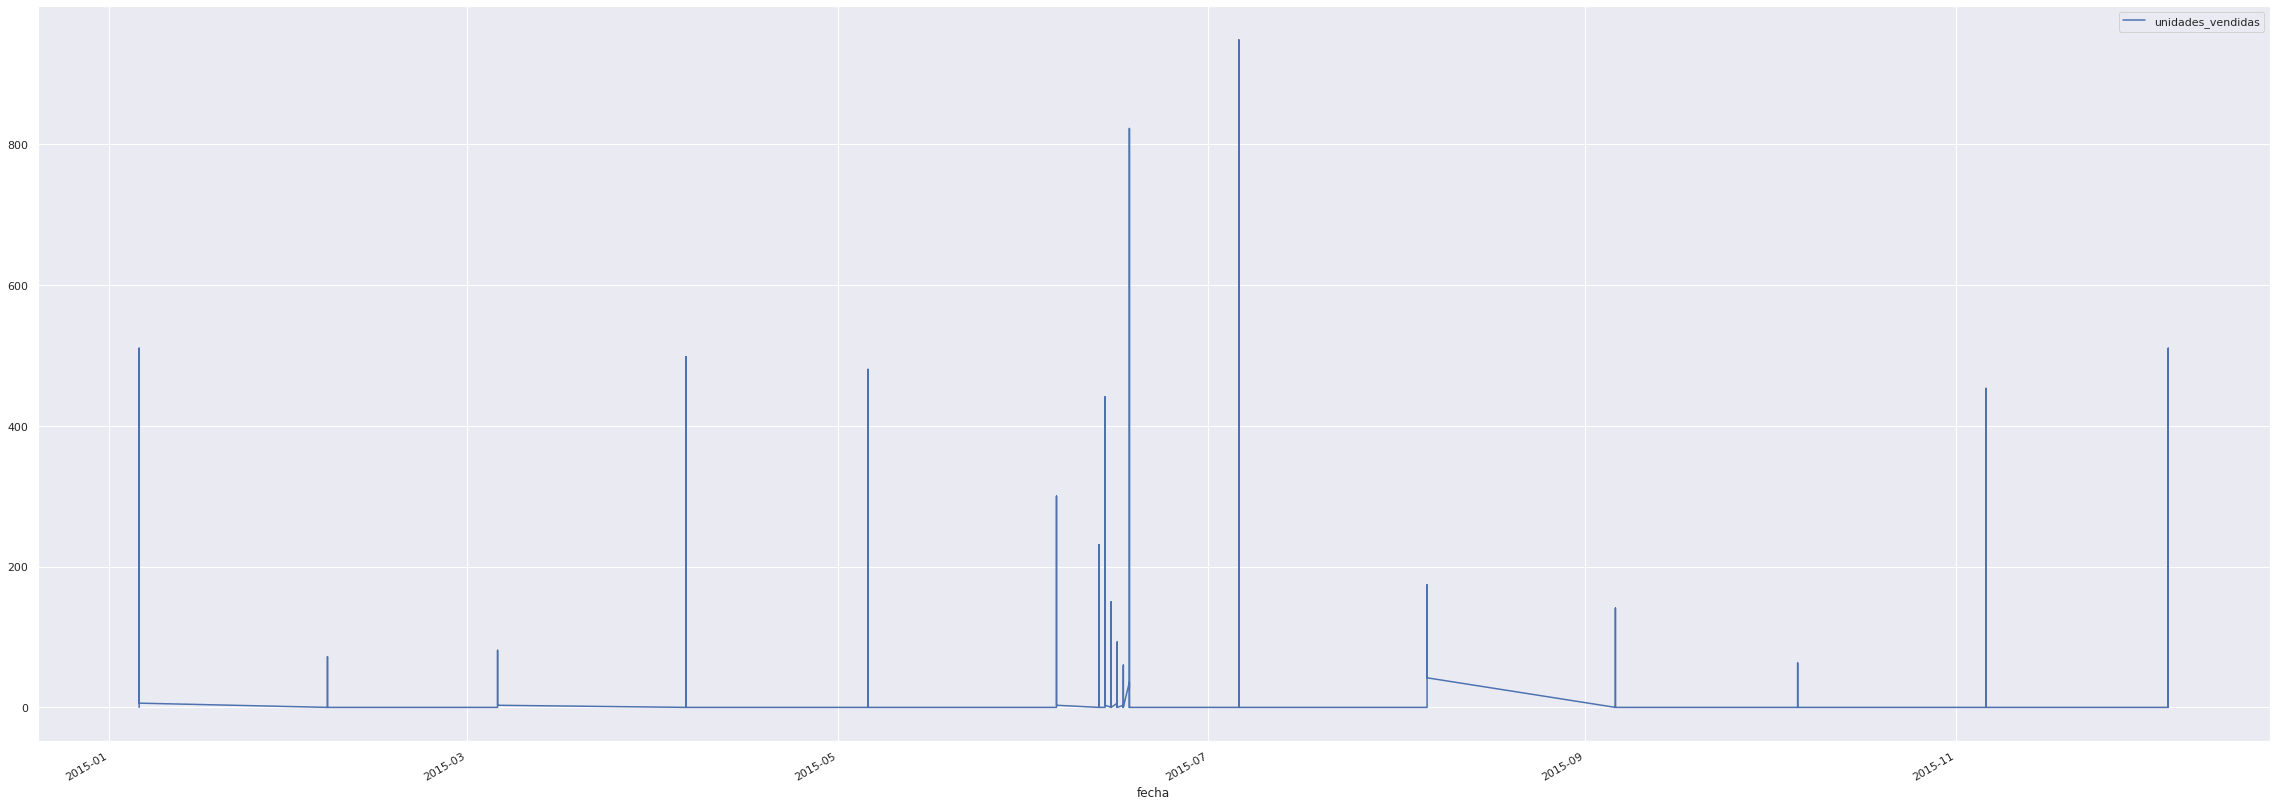

In [14]:
df[['fecha','unidades_vendidas']].set_index('fecha').plot(figsize=(40,15))

Vamos a observar una visión generalizada de la relación entre variables, teniendo en cuenta nuestra variable a predecir. Esto nos ayudará a saber en qué atributos centrarnos y cuál es la manera en la que se relacionan.

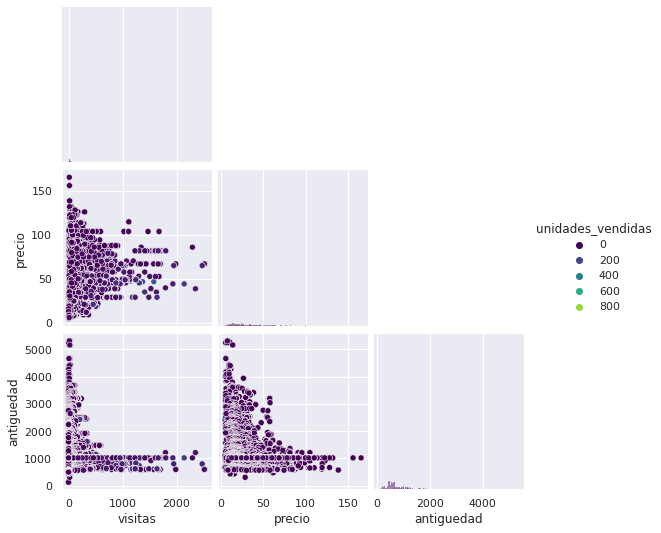

In [15]:
df_correlacion = df.drop(["id", "categoria_dos", "dia_atipico", "campaña"], axis=1)
sns.pairplot(df_correlacion, hue = "unidades_vendidas", diag_kind = "hist", corner = True, palette="viridis")

Podemos observar varias cosas gracias a esta visión general:

*   Existe una tendencia clara entre "precio" y "antigüedad", en la que cuando esta última disminuye, así lo hace también el precio.

*   Podemos observar otra tendencia igual de clara entre las variables "visitas" y "antigüedad", donde a mayor antiguedad de producto, menores visitas encontramos.

Pero lo que realmente nos interesa es cómo estas relaciones afectan a las unidades vendidas, que es nuestra variable a predecir. La conclusión que podemos sacar lógica y que se confirma en los gráficos que observamos arriba es:

*   Cuanto menor es el precio y la antigüedad, las unidades vendidas se incrementan de manera notoria.

Esta relación resulta muy importante a la hora de realizar una predicción. No obstante, respecto a la segunda tendencia que hemos observado antes, existe una relación no tan lógica como la anterior y es que:

*   Cuanto más nuevo y más visitas tenga el producto, no siempre se vende más. De hecho, la mayoría de las unidades vendidas se centran en la franja entre las 0 y las 1000 visitas, siempre y cuando el producto sea novedoso.

Esto también es un factor importante a tener en cuenta en un futuro.





1.   **CATEGORIA_UNO**

---





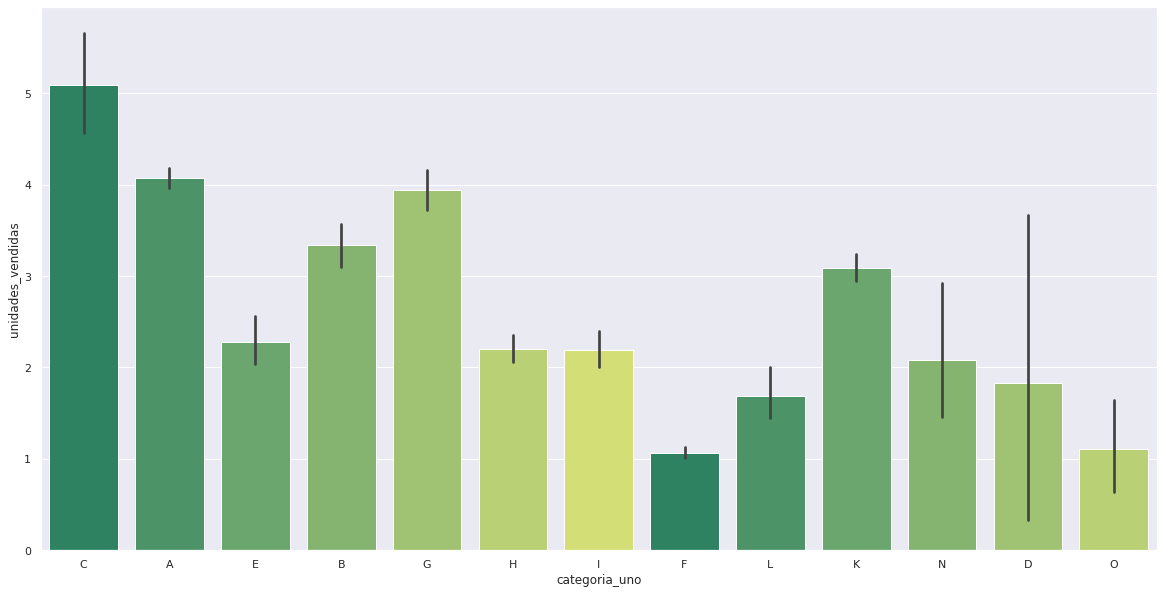

In [35]:
sns.barplot(x="categoria_uno", y="unidades_vendidas", data=df, palette=sns.color_palette("summer", 7))

2. **CATEGORIA_DOS**

---



In [55]:
aux = df.drop(["id", "campaña", "precio", "antiguedad", "visitas", "dia_atipico", "fecha"], axis=1)
df_melted = aux.melt("categoria_uno", var_name = "a", value_name = "b")
print(df_melted)
sns.barplot(x="categoria_uno", y="b", data=df_melted, palette=sns.color_palette("summer", 7))

       categoria_uno                  a      b
0                  C      categoria_dos   75.0
1                  C      categoria_dos  170.0
2                  A      categoria_dos   46.0
3                  A      categoria_dos   46.0
4                  E      categoria_dos  230.0
...              ...                ...    ...
442744             A  unidades_vendidas      0
442745             A  unidades_vendidas      0
442746             A  unidades_vendidas      0
442747             A  unidades_vendidas      0
442748             A  unidades_vendidas    NaN

[442749 rows x 3 columns]


TypeError: ignored

3. **CAMPAÑA**

---



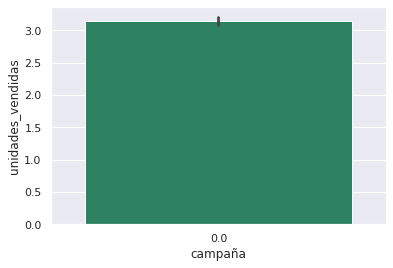

In [18]:
sns.barplot(x="campaña", y="unidades_vendidas", data=df, palette=sns.color_palette("summer", 7))